In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import seaborn as sns

from src.est import *
from src.utils import *

# 1 - Prepare data

In [18]:
df_trips = pd.read_parquet("data/yellow_tripdata_2024-01.parquet")
df_zones = pd.read_csv("data/taxi_zones.csv")

In [19]:
def get_longitude(polygon):
    multipolygon = wkt.loads(polygon)
    centroid = multipolygon.centroid
    longitude = centroid.x
    return longitude

def get_latitude(polygon):
    multipolygon = wkt.loads(polygon)
    centroid = multipolygon.centroid
    latitude = centroid.y
    return latitude

df_zones['lon'] = df_zones['the_geom'].apply(get_longitude)
df_zones['lat'] = df_zones['the_geom'].apply(get_latitude)

df_trips = df_trips.merge(
    df_zones[['LocationID', 'borough', 'zone', 'lon', 'lat']], 
    left_on='PULocationID', 
    right_on='LocationID', 
    suffixes=('', '_PU')
)
df_trips.rename(columns={'lon': 'PUlon', 'lat': 'PUlat', 'borough': 'PUborough', 'zone': 'PUzone'}, inplace=True)

df_trips = df_trips.merge(
    df_zones[['LocationID', 'borough', 'zone', 'lon', 'lat']], 
    left_on='DOLocationID', 
    right_on='LocationID', 
    suffixes=('', '_DO')
)
df_trips.rename(columns={'lon': 'DOlon', 'lat': 'DOlat', 'borough': 'DOborough', 'zone': 'DOzone'}, inplace=True)

df_trips.drop(columns=['LocationID', 'LocationID_DO'], inplace=True)

In [20]:
neighborhoods_south_of_harlem = [
    'Alphabet City', 'Battery Park', 'Battery Park City', 'Central Park',
    'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 
    'East Village', 'Financial District North', 'Financial District South', 
    'Flatiron', 'Hudson Sq', 'Garment District', 
    "Governor's Island/Ellis Island/Liberty Island", 'Gramercy', 
    'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 
    'Lincoln Square West', 'Little Italy/NoLiTa', 'Lower East Side', 
    'Meatpacking/West Village West', 'Midtown Center', 'Midtown East', 
    'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'Seaport', 'SoHo', 
    'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North', 
    'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'Two Bridges/Seward Park', 'UN/Turtle Bay South', 'Union Sq', 
    'Upper East Side North', 'Upper East Side South', 'Upper West Side South', 
    'Washington Heights South', 'West Chelsea/Hudson Yards', 'West Village', 
    'World Trade Center', 'Yorkville East', 'Yorkville West'
]

neighborhoods_from_central_park_to_south = [
    'Alphabet City', 'Battery Park', 'Battery Park City', 'Central Park',
    'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 
    'East Village', 'Financial District North', 'Financial District South', 
    'Flatiron', 'Hudson Sq', 'Garment District', 
    "Governor's Island/Ellis Island/Liberty Island", 'Gramercy', 
    'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 
    'Lincoln Square West', 'Little Italy/NoLiTa', 'Lower East Side', 
    'Meatpacking/West Village West', 'Midtown Center', 'Midtown East', 
    'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'Seaport', 'SoHo', 
    'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North', 
    'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'Two Bridges/Seward Park', 'UN/Turtle Bay South', 'Union Sq', 
    'Upper East Side North', 'Upper East Side South', 'Upper West Side South', 
    'West Chelsea/Hudson Yards', 'West Village', 'World Trade Center', 
    'Yorkville East', 'Yorkville West'
]

neighborhoods_central_park_to_north_of_battery_park = [
    'Alphabet City', 'Central Park', 'Chinatown', 'Clinton East', 'Clinton West', 
    'East Chelsea', 'East Village', 'Flatiron', 'Hudson Sq', 'Garment District', 
    'Gramercy', 'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 'Lincoln Square West', 
    'Little Italy/NoLiTa', 'Lower East Side', 'Meatpacking/West Village West', 
    'Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'SoHo', 'Stuy Town/Peter Cooper Village', 
    'Sutton Place/Turtle Bay North', 'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'UN/Turtle Bay South', 'Union Sq', 'Upper East Side North', 'Upper East Side South', 
    'Upper West Side South', 'West Chelsea/Hudson Yards', 'West Village', 'Yorkville East', 
    'Yorkville West'
]

df_trips_manhattan = df_trips[
    (df_trips['PUborough'] == 'Manhattan') & 
    (df_trips['DOborough'] == 'Manhattan') & 
    (df_trips['PUzone'].isin(neighborhoods_from_central_park_to_south)) & 
    (df_trips['DOzone'].isin(neighborhoods_from_central_park_to_south))
].copy()

In [21]:
angle_degrees = -29
angle_radians = np.radians(angle_degrees)

rotation_matrix = np.array([
    [np.cos(angle_radians), -np.sin(angle_radians)],
    [np.sin(angle_radians), np.cos(angle_radians)]
])

df_trips_manhattan[['PUlon_rot', 'PUlat_rot']] = df_trips_manhattan[['PUlon', 'PUlat']].dot(rotation_matrix)
df_trips_manhattan[['DOlon_rot', 'DOlat_rot']] = df_trips_manhattan[['DOlon', 'DOlat']].dot(rotation_matrix)

In [22]:
n_bins = 10

min_rot_lon = min(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].min())
max_rot_lon = max(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].max())
min_rot_lat = min(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].min())
max_rot_lat = max(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].max())

df_trips_manhattan['PUlon_bin'] = pd.cut(df_trips_manhattan['PUlon_rot'], bins=n_bins, labels=False)
df_trips_manhattan['PUlat_bin'] = pd.cut(df_trips_manhattan['PUlat_rot'], bins=n_bins, labels=False)
df_trips_manhattan['DOlon_bin'] = pd.cut(df_trips_manhattan['DOlon_rot'], bins=n_bins, labels=False)
df_trips_manhattan['DOlat_bin'] = pd.cut(df_trips_manhattan['DOlat_rot'], bins=n_bins, labels=False)

In [23]:
M_ten = np.zeros((n_bins, n_bins))  # Marginal probability of pickup states
Q_ten = np.zeros((n_bins, n_bins, n_bins, n_bins))  # Joint distribution of transitions
P = np.zeros((n_bins, n_bins, n_bins, n_bins))  # Conditional transition probabilities

for _, row in df_trips_manhattan.iterrows():
    pu_lat_idx = row['PUlat_bin']
    pu_lon_idx = row['PUlon_bin']
    do_lat_idx = row['DOlat_bin']
    do_lon_idx = row['DOlon_bin']

    M_ten[pu_lat_idx, pu_lon_idx] += 1

    Q_ten[pu_lat_idx, pu_lon_idx, do_lat_idx, do_lon_idx] += 1

M_ten_sum = M_ten.sum()
if M_ten_sum > 0:
    M_ten = M_ten / M_ten_sum
M_vec = M_ten.flatten()

Q_ten_sum = Q_ten.sum()
if Q_ten_sum > 0:
    Q_ten = Q_ten / Q_ten_sum
Q_mat = Q_ten.reshape(n_bins * n_bins, n_bins * n_bins)

P_sum = Q_ten.sum(axis=(2, 3), keepdims=True)
P_sum[P_sum == 0] = 1
P_ten = Q_ten / P_sum
P_mat = P_ten.reshape(n_bins * n_bins, n_bins * n_bins)

# 2 - Visualizations

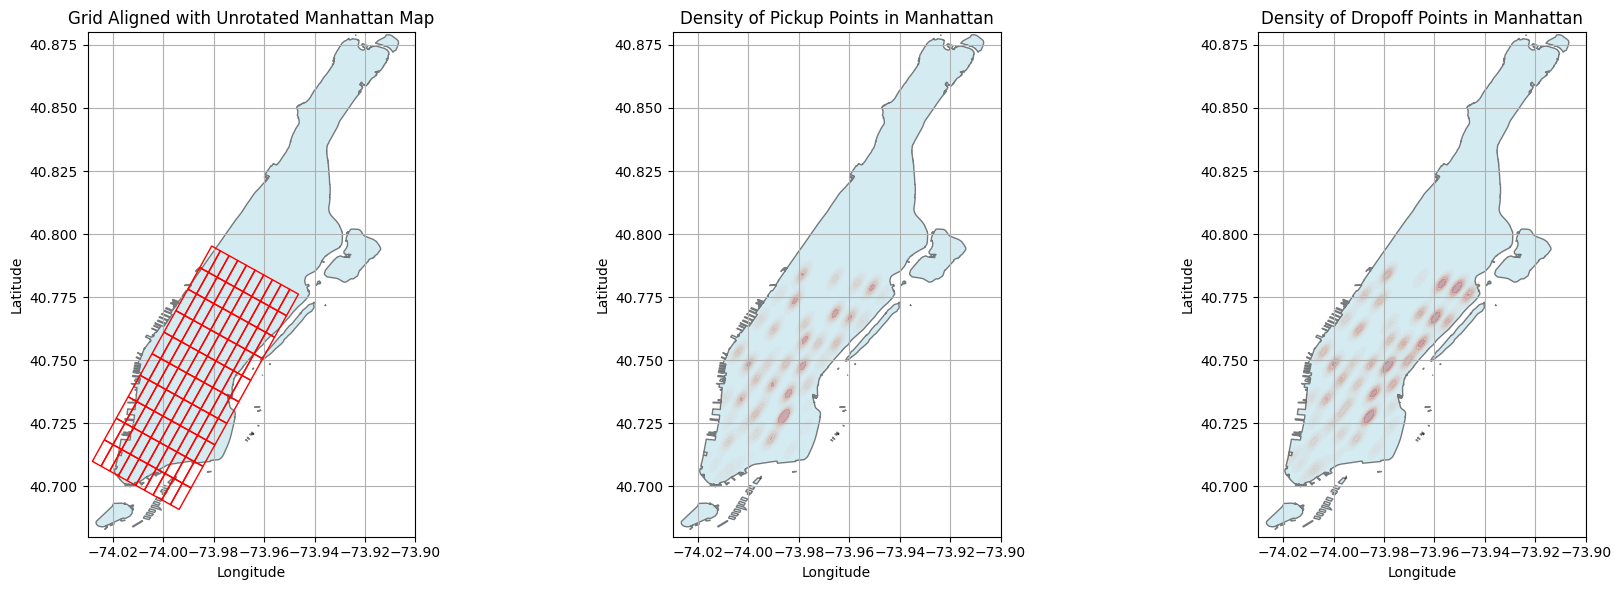

In [24]:
def rotate_back(lon, lat, angle):
    radians = np.radians(angle)
    cos_angle = np.cos(radians)
    sin_angle = np.sin(radians)
    x_rot = cos_angle * lon + sin_angle * lat
    y_rot = -sin_angle * lon + cos_angle * lat
    return x_rot, y_rot

def create_grid_from_rotated_bbox(min_rot_lat, max_rot_lat, min_rot_lon, max_rot_lon, n_cells, rotation_angle):
    lat_points = np.linspace(min_rot_lat, max_rot_lat, n_cells + 1)
    lon_points = np.linspace(min_rot_lon, max_rot_lon, n_cells + 1)

    grid_cells = []
    for i in range(n_cells):
        for j in range(n_cells):
            x0, y0 = lon_points[i], lat_points[j]
            x1, y1 = lon_points[i + 1], lat_points[j + 1]

            rotated_corners = [
                (x0, y0),
                (x1, y0),
                (x1, y1),
                (x0, y1)
            ]
            unrotated_corners = [rotate_back(lon, lat, rotation_angle) for lon, lat in rotated_corners]
            grid_cells.append(Polygon(unrotated_corners))
    
    return grid_cells

min_rot_lon = min(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].min())
max_rot_lon = max(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].max())
min_rot_lat = min(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].min())
max_rot_lat = max(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].max())

rotation_angle = 29

grid_cells = create_grid_from_rotated_bbox(min_rot_lat, max_rot_lat, min_rot_lon, max_rot_lon, n_bins, rotation_angle)
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs="EPSG:4326")

manhattan_url = 'https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson'
manhattan_gdf = gpd.read_file(manhattan_url)
manhattan_gdf = manhattan_gdf[manhattan_gdf['boro_name'] == 'Manhattan']

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
manhattan_gdf.plot(ax=plt.gca(), color='lightblue', alpha=0.5, edgecolor='black')
grid_gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1)
plt.xlim(-74.03, -73.90)
plt.ylim(40.68, 40.88)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Grid Aligned with Unrotated Manhattan Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.subplot(1, 3, 2)
sns.kdeplot(
    x=df_trips_manhattan['PUlon'].head(10_000),
    y=df_trips_manhattan['PUlat'].head(10_000),
    ax=plt.gca(),
    cmap='Reds',
    fill=True,
    alpha=0.6,
    bw_adjust=0.5,
    clip=[(-74.03, -73.90), (40.68, 40.88)]
)
manhattan_gdf.plot(ax=plt.gca(), color='lightblue', alpha=0.5, edgecolor='black')
plt.xlim(-74.03, -73.90)
plt.ylim(40.68, 40.88)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Density of Pickup Points in Manhattan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.subplot(1, 3, 3)
sns.kdeplot(
    x=df_trips_manhattan['DOlon'].head(10_000),
    y=df_trips_manhattan['DOlat'].head(10_000),
    ax=plt.gca(),
    cmap='Reds',
    fill=True,
    alpha=0.6,
    bw_adjust=0.5,
    clip=[(-74.03, -73.90), (40.68, 40.88)]
)
manhattan_gdf.plot(ax=plt.gca(), color='lightblue', alpha=0.5, edgecolor='black')
plt.xlim(-74.03, -73.90)
plt.ylim(40.68, 40.88)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Density of Dropoff Points in Manhattan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.tight_layout()
plt.show()


In [119]:
df_trips_manhattan.head(1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,DOlon,DOlat,PUlon_rot,PUlat_rot,DOlon_rot,DOlat_rot,PUlon_bin,PUlat_bin,DOlon_bin,DOlat_bin
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,-73.985937,40.72762,-84.470507,-0.232807,-84.454701,-0.247915,3,5,7,3


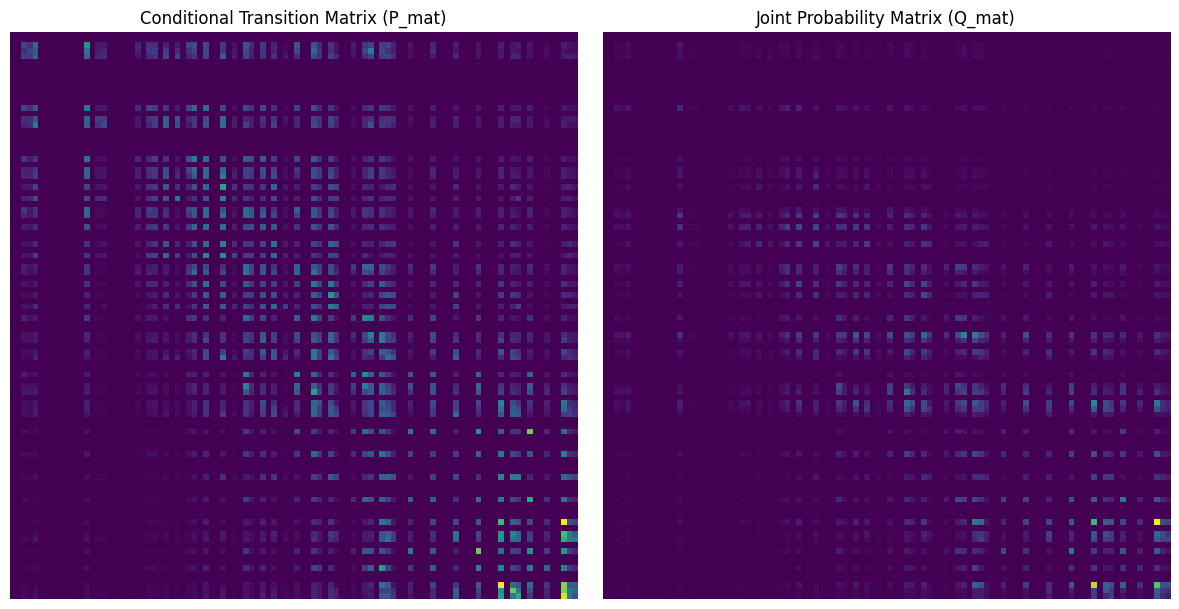

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(P_mat, cmap='viridis')
plt.title('Conditional Transition Matrix (P_mat)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Q_mat, cmap='viridis')
plt.title('Joint Probability Matrix (Q_mat)')
plt.axis('off')

plt.tight_layout()
plt.show()

# 3 - Estimation

In [33]:
def get_chain(df, n):
    M_ten = np.zeros((n_bins, n_bins))  # Marginal probability of pickup states
    Q_ten = np.zeros((n_bins, n_bins, n_bins, n_bins))  # Joint distribution of transitions
    P = np.zeros((n_bins, n_bins, n_bins, n_bins))  # Conditional transition probabilities

    for _, row in df.sample(n=n).iterrows():
        pu_lat_idx = row['PUlat_bin']
        pu_lon_idx = row['PUlon_bin']
        do_lat_idx = row['DOlat_bin']
        do_lon_idx = row['DOlon_bin']

        M_ten[pu_lat_idx, pu_lon_idx] += 1

        Q_ten[pu_lat_idx, pu_lon_idx, do_lat_idx, do_lon_idx] += 1

    Q_ten_sum = Q_ten.sum()
    if Q_ten_sum > 0:
        Q_ten = Q_ten / Q_ten_sum
    Q_mat = Q_ten.reshape(n_bins * n_bins, n_bins * n_bins)

    P_sum = Q_ten.sum(axis=(2, 3), keepdims=True)
    P_sum[P_sum == 0] = 1
    P_ten = Q_ten / P_sum
    P_mat = P_ten.reshape(n_bins * n_bins, n_bins * n_bins)
    return P_ten, P_mat, Q_ten, Q_mat

In [38]:
P_mat = torch.tensor(P_mat).float()
Q_mat = torch.tensor(Q_mat).float()
M_vec = torch.tensor(M_vec).float()

P_ten = torch.tensor(P_ten).float()
Q_ten = torch.tensor(Q_ten).float()
M_ten = torch.tensor(M_ten).float()

num_trials = 5
N = torch.tensor([10, 10]) # No. states per dimension

mcs = []
P_tru = []; Q_tru = []; P_1D_tru = []; Q_1D_tru = []
for t in range(num_trials):
    mc = MarkovChainMatrix(P_mat)
    mc.pi = M_vec
    mc.Q = Q_mat
    mcs.append(mc)

    P_tru.append(mc.P.reshape(tuple(N.repeat(2))))
    Q_tru.append(mc.Q.reshape(tuple(N.repeat(2))))
    P_1D_tru.append(mc.P.clone())
    Q_1D_tru.append(mc.Q.clone())

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_17530/2514049912.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M_vec = torch.tensor(M_vec).float()
/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_17530/2514049912.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M_ten = torch.tensor(M_ten).float()


In [101]:
P_1D_obs, Q_1D_obs = [[] for _ in range(num_trials)], [[] for _ in range(num_trials)]
P_obs, Q_obs = [[] for _ in range(num_trials)], [[] for _ in range(num_trials)]
for t in range(num_trials):
    for n in [10, 100, 1_000, 5_000, 10_000]:
        P_ten, P_mat, Q_ten, Q_mat = get_chain(df_trips_manhattan, n)

        P_mat = torch.tensor(P_mat).float()
        Q_mat = torch.tensor(Q_mat).float()
        P_ten = torch.tensor(P_ten).float()
        Q_ten = torch.tensor(Q_ten).float()

        P_1D_obs[t].append(P_mat)
        Q_1D_obs[t].append(Q_mat)
        P_obs[t].append(P_ten)
        Q_obs[t].append(Q_ten)

In [102]:
SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
verbose = False

eps_abs = 1e-6
eps_rel = 1e-6
eps_diff = 1e-6

100%|██████████| 20000/20000 [00:31<00:00, 628.53it/s]


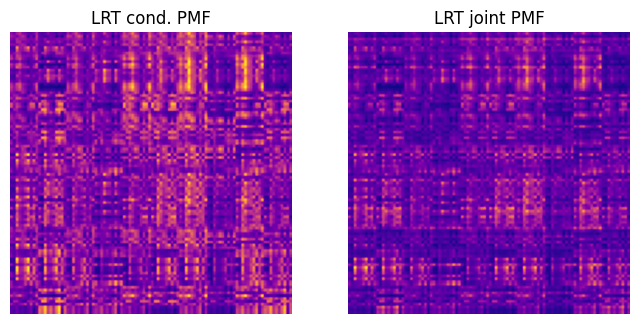

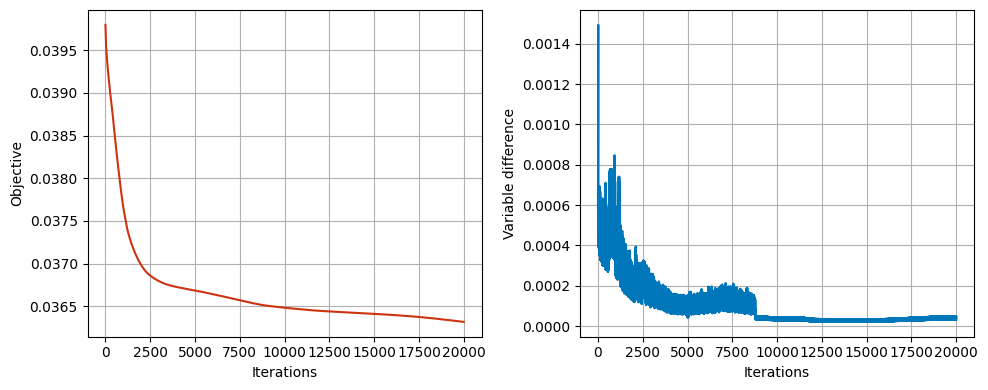

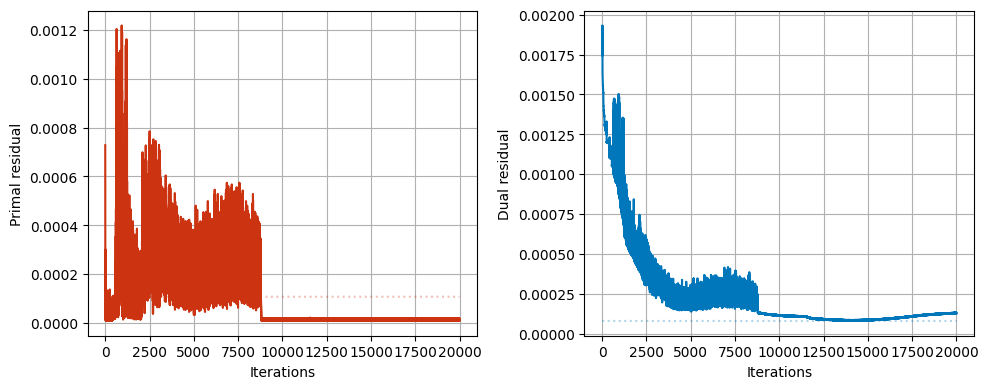

In [117]:
# Low-rank tensor estimation
T_range = np.logspace(3, 5, 5).astype(int)

lrte_est_parallel = lambda lrte, Qh, lrt_args: lrte.estimate(Qh, lrt_args)

lrt_args = {
    'K':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'verbose':verbose,
    'MARG_CONST':True,
    'ACCEL':True
}

lrte = [[LowRankTensorEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
lrt_args['K'] = 20 # 50
lrt_args['beta'] = .1 # .01
lrt_args['max_itr'] = 20_000 # 5_000
results = Parallel(n_jobs=num_cpus)(delayed(lrte_est_parallel)( lrte[t][i],Q_obs[t][i],lrt_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_lrt[t][i] = results[c][0].P_1D
        Q_1D_lrt[t][i] = results[c][0].Q_1D
        res_lrt[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_lrt[t][i],'plasma'); ax[1].imshow(Q_1D_lrt[t][i],'plasma')
ax[0].set_title('LRT cond. PMF'); ax[1].set_title('LRT joint PMF')

err_lrt_P = torch.tensor([[frob_err(P_1D_lrt[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_Q = torch.tensor([[frob_err(Q_1D_lrt[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = 4
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_lrt[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_lrt[t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_lrt[t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_lrt[t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()

100%|██████████| 5000/5000 [00:05<00:00, 895.98it/s]


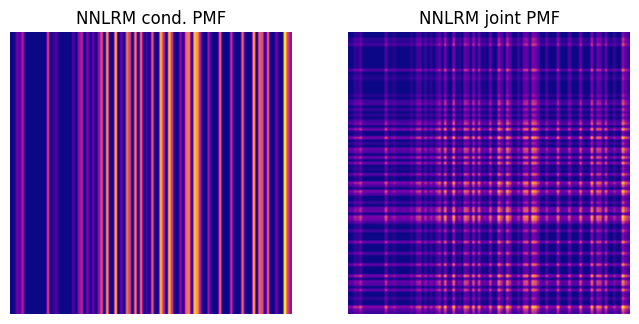

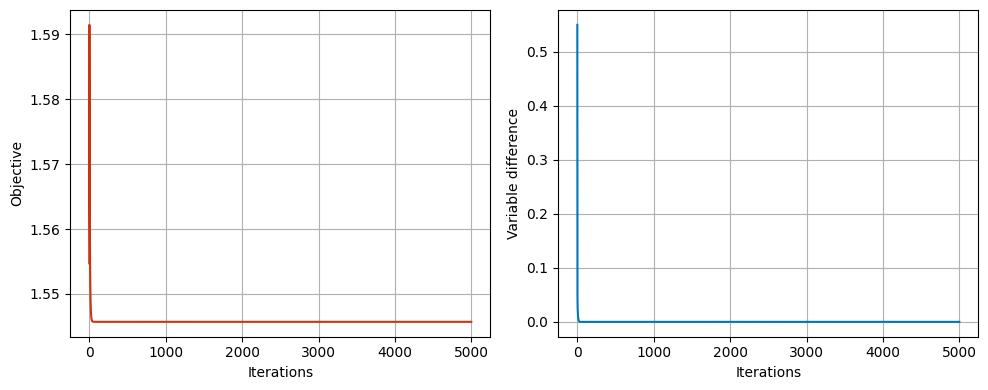

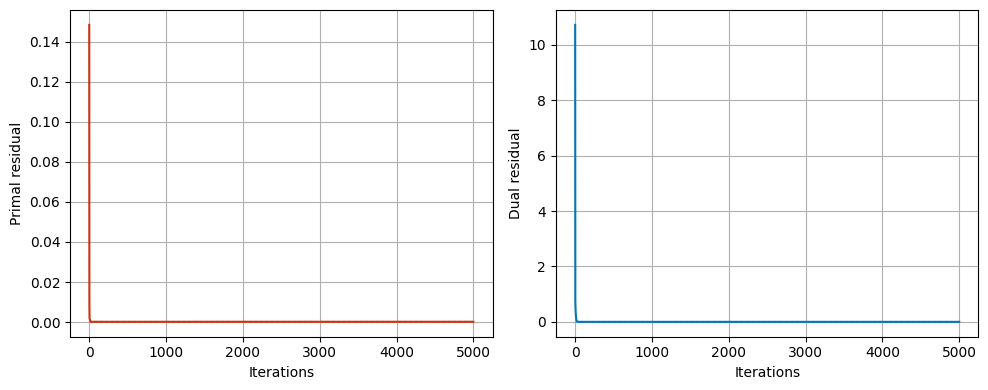

In [105]:
# Nuclear norm matrix estimation

nnlrme_est_parallel = lambda nnlrm,Ph,args: nnlrm.estimate(Ph,args)

nnlrm_args = {
    'beta':None,
    'gamma':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'verbose':False
}

nnlrme = [[NucNormMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
nnlrm_args['beta'] = 10
nnlrm_args['gamma'] = .8
nnlrm_args['max_itr'] = 5000
results = Parallel(n_jobs=num_cpus)(delayed(nnlrme_est_parallel)( nnlrme[t][i],P_1D_obs[t][i],nnlrm_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_nnlrm[t][i] = results[c][0].P
        Q_1D_nnlrm[t][i] = results[c][0].Q
        res_nnlrm[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_nnlrm[t][i],'plasma'); ax[1].imshow(Q_1D_nnlrm[t][i],'plasma')
ax[0].set_title('NNLRM cond. PMF'); ax[1].set_title('NNLRM joint PMF')

err_nnlrm_P = torch.tensor([[frob_err(P_1D_nnlrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_Q = torch.tensor([[frob_err(Q_1D_nnlrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = -1
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_nnlrm[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_nnlrm[t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_nnlrm[t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_nnlrm[t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()


100%|██████████| 500/500 [00:01<00:00, 490.28it/s]


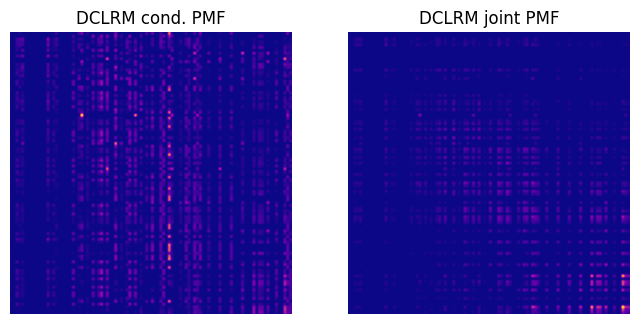

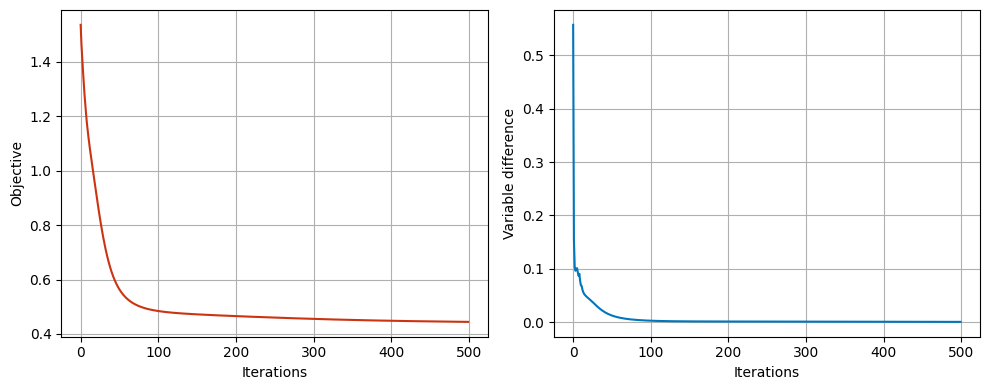

In [106]:
# Low-rank matrix estimation via DC algorithm

dclrme_est_parallel = lambda dclrm,Ph,args: dclrm.estimate(Ph,args)

dclrm_args = {
    'K':None,
    'c':None,
    'alpha':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'admm_itr':1,
    'verbose':False
}

dclrme = [[DCLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
dclrm_args['K'] = 10
dclrm_args['c'] = 5
dclrm_args['alpha'] = .5
dclrm_args['beta'] = 1
dclrm_args['max_itr'] = 500
dclrm_args['admm_itr'] = 1
results = Parallel(n_jobs=num_cpus)(delayed(dclrme_est_parallel)( dclrme[t][i],P_1D_obs[t][i],dclrm_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_dclrm[t][i] = results[c][0].P
        Q_1D_dclrm[t][i] = results[c][0].Q
        res_dclrm[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_dclrm[t][i],'plasma'); ax[1].imshow(Q_1D_dclrm[t][i],'plasma')
ax[0].set_title('DCLRM cond. PMF'); ax[1].set_title('DCLRM joint PMF')

err_dclrm_P = torch.tensor([[frob_err(P_1D_dclrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_Q = torch.tensor([[frob_err(Q_1D_dclrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = -1
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_dclrm[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_dclrm[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()


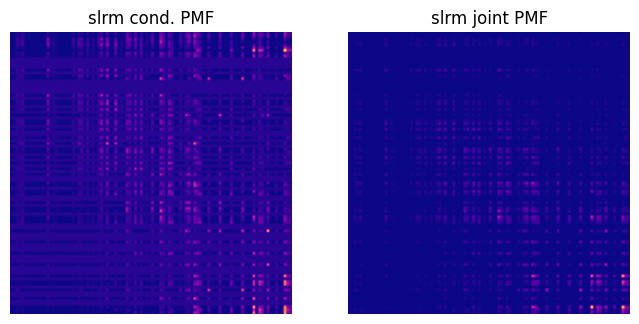

In [107]:
# Spectral low-rank matrix estimation

slrme_est_parallel = lambda slrm,Qh,K: slrm.estimate(Qh,K)

slrme = [[SpecLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
K_slrme = 10
# results = [[slrme[t][i].estimate(Q_1D_obs[t][i],K_slrme) for i in range(len(T_range))] for t in range(num_trials)]
results = Parallel(n_jobs=num_cpus)(delayed(slrme_est_parallel)( slrme[t][i],Q_1D_obs[t][i],K_slrme ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_slrm[t][i] = results[c][0].P
        Q_1D_slrm[t][i] = results[c][0].Q
        res_slrm[t][i] = results[c][1]
        c+=1

i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_slrm[t][i],'plasma'); ax[1].imshow(Q_1D_slrm[t][i],'plasma')
ax[0].set_title('slrm cond. PMF'); ax[1].set_title('slrm joint PMF')

err_slrm_P = torch.tensor([[frob_err(P_1D_slrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_Q = torch.tensor([[frob_err(Q_1D_slrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])


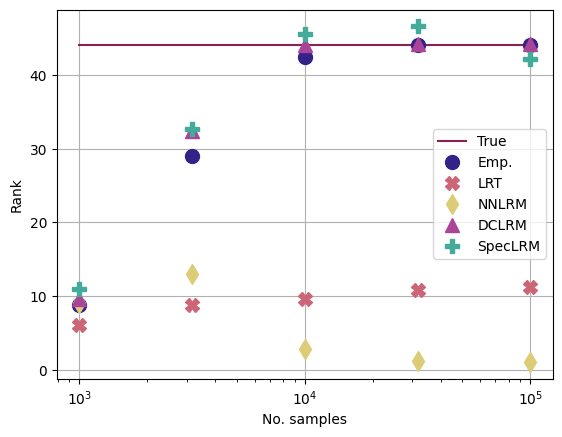

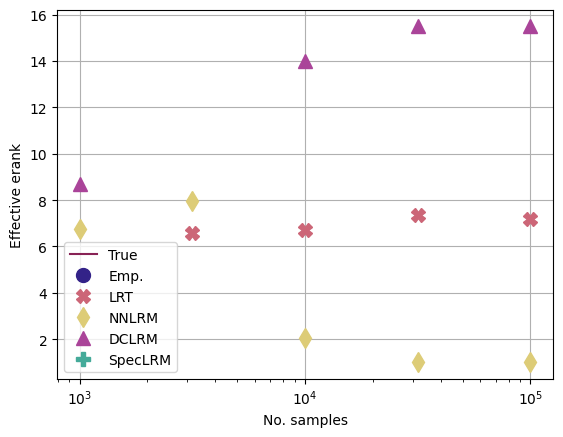

In [108]:
# Computing the rank of conditional PMFs

rank_obs = torch.tensor([[torch.linalg.matrix_rank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_lrt = torch.tensor([[torch.linalg.matrix_rank(P_1D_lrt[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_nnlrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_nnlrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_dclrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_dclrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_slrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_slrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)

erank_obs = torch.tensor([[erank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_lrt = torch.tensor([[erank(P_1D_lrt[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_nnlrm = torch.tensor([[erank(P_1D_nnlrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_dclrm = torch.tensor([[erank(P_1D_dclrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_slrm = torch.tensor([[erank(P_1D_slrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)

erank_tru = torch.tensor([erank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)
rank_tru = torch.tensor([torch.linalg.matrix_rank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)

# Plot rank
clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, [rank_tru.mean(0)]*len(T_range), '-', c=clr_list[-1], label=methods[-1], markersize=10, zorder = 3 )
ax.semilogx( T_range, rank_obs.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_lrt.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, rank_nnlrm.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_dclrm.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_slrm.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Rank'); ax.legend()

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, [erank_tru.mean(0)]*len(T_range), '-', c=clr_list[-1], label=methods[-1], markersize=10, zorder = 3 )
ax.semilogx( T_range, erank_obs.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_lrt.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, erank_nnlrm.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_dclrm.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_slrm.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Effective erank'); ax.legend()

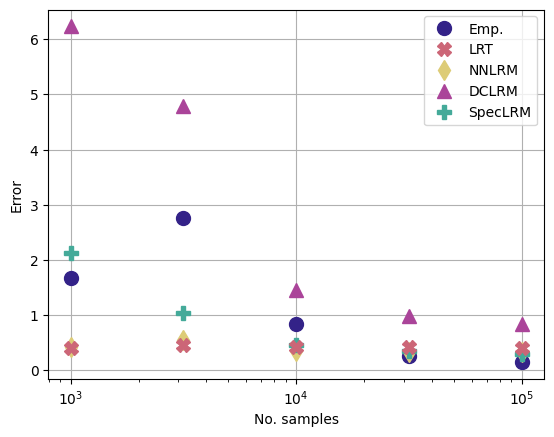

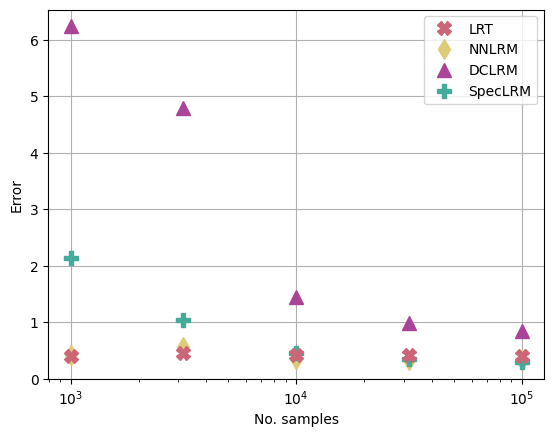

In [118]:
# Compute error of conditional PMFs

err_obs_P = torch.tensor([[normfrob_err(P_1D_obs[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_obs_Q = torch.tensor([[normfrob_err(Q_1D_obs[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_P = torch.tensor([[normfrob_err(P_1D_lrt[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_Q = torch.tensor([[normfrob_err(Q_1D_lrt[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_P = torch.tensor([[normfrob_err(P_1D_nnlrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_Q = torch.tensor([[normfrob_err(Q_1D_nnlrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_P = torch.tensor([[normfrob_err(P_1D_dclrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_Q = torch.tensor([[normfrob_err(Q_1D_dclrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_P = torch.tensor([[normfrob_err(P_1D_slrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_Q = torch.tensor([[normfrob_err(Q_1D_slrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

# Plot error
clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_obs_P.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()

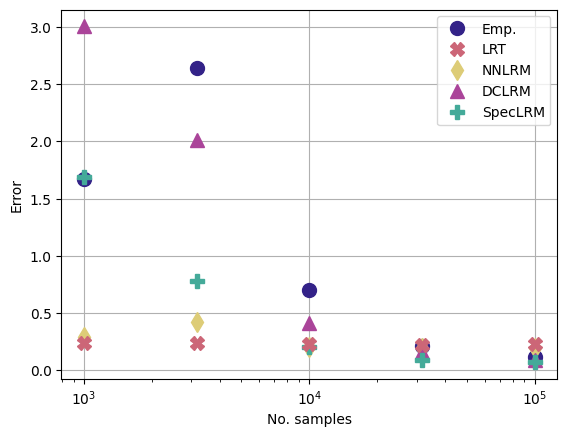

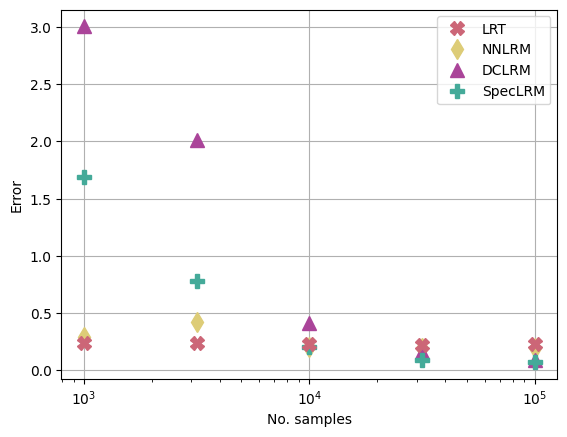

In [110]:
def compute_filtered_error(observed, true):
    mask = true != 0
    return (normfrob_err(observed * mask, true) ** 2)

# Calculate errors for P and Q matrices, considering only non-zero true values
err_obs_P = torch.tensor([[compute_filtered_error(P_1D_obs[t][i], P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_obs_Q = torch.tensor([[compute_filtered_error(Q_1D_obs[t][i], Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_P = torch.tensor([[compute_filtered_error(P_1D_lrt[t][i], P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_Q = torch.tensor([[compute_filtered_error(Q_1D_lrt[t][i], Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_P = torch.tensor([[compute_filtered_error(P_1D_nnlrm[t][i], P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_Q = torch.tensor([[compute_filtered_error(Q_1D_nnlrm[t][i], Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_P = torch.tensor([[compute_filtered_error(P_1D_dclrm[t][i], P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_Q = torch.tensor([[compute_filtered_error(Q_1D_dclrm[t][i], Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_P = torch.tensor([[compute_filtered_error(P_1D_slrm[t][i], P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_Q = torch.tensor([[compute_filtered_error(Q_1D_slrm[t][i], Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)])


# Plot error
clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_obs_P.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()